In [43]:
import sys
# necessary to find ros packages
sys.path.append('/opt/ros/humble/local/lib/python3.10/dist-packages')

import numpy as np
import matplotlib.pyplot as plt
import yaml

from models.point import Point, RefPoint
from models.map import Map
from models.pose import Pose
from utils.classify_points import classify_points
from utils.extract_track_borders import extract_track_borders
from utils.get_center_line import get_center_line
from utils.trajectory_from_points import trajectory_from_path
import math

from path_find_algorithms.A_star.A_star import AStar
import csv

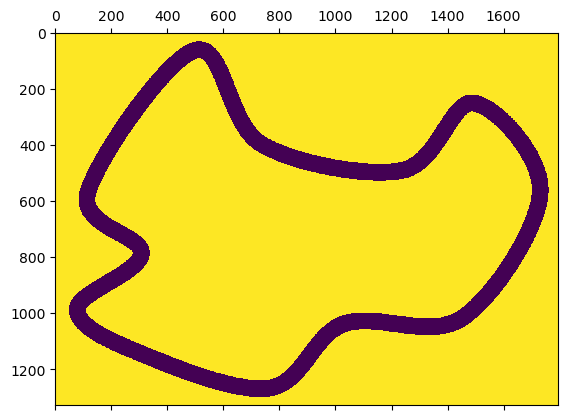

In [44]:
with open('../../../to_be_saved/tracks/track_3/costmap/map.npy', 'rb') as f:
    occupancy_grid = np.load(f)

with (open('../../../to_be_saved/tracks/track_3/costmap/map.yaml', 'rb')) as f:
    occupancy_grid_config = yaml.safe_load(f)

occupancy_grid = (occupancy_grid != 0) * 1

resolution = occupancy_grid_config["resolution"]
occupancy_map = Map(occupancy_grid, resolution, Point(occupancy_grid_config["origin_x"] - resolution, occupancy_grid_config["origin_y"] -resolution))

plt.matshow(occupancy_map.grid)

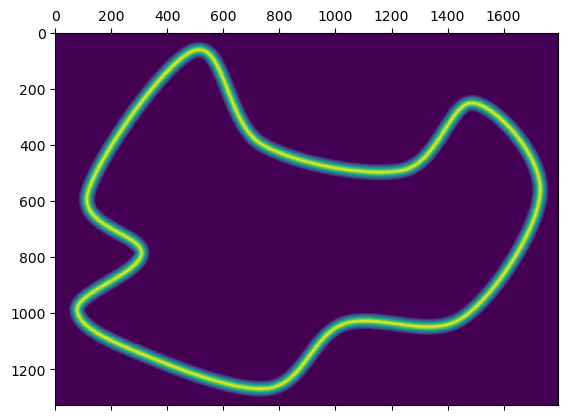

In [62]:
from scipy import ndimage
binarized_grid = occupancy_map.grid == 0
distance = ndimage.distance_transform_edt(binarized_grid)
plt.matshow(distance)


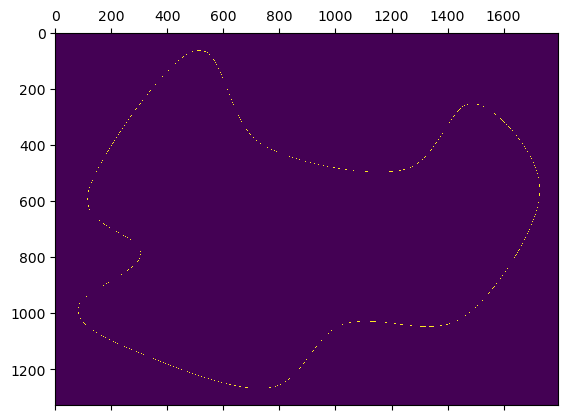

In [60]:
from skimage.morphology import skeletonize
binarized_grid = occupancy_map.grid == 0
skeleton = skeletonize(binarized_grid)
plt.matshow(skeleton)

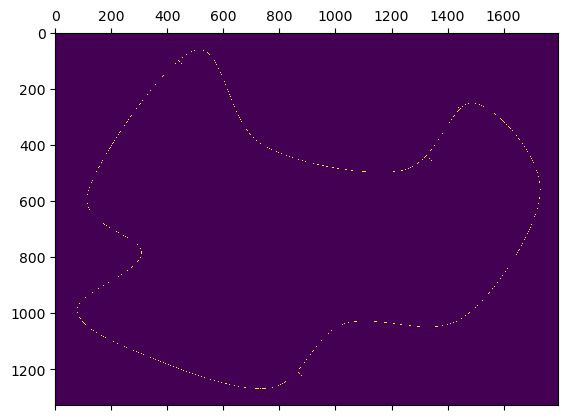

In [61]:
from skimage.morphology import medial_axis
from fil_finder import FilFinder2D
import astropy.units as u

binarized_grid = occupancy_map.grid == 0
skeleton, distances = medial_axis(binarized_grid, return_distance=True)
plt.matshow(skeleton)

In [58]:
fil = FilFinder2D(skeleton*1, distance=250 * u.pc, mask=skeleton)
fil.preprocess_image(flatten_percent=85)
fil.create_mask(border_masking=True, verbose=False,
use_existing_mask=True)
fil.medskel(verbose=False)
fil.analyze_skeletons(branch_thresh=40* u.pix, skel_thresh=10 * u.pix, prune_criteria='length')

/home/tim/.local/lib/python3.10/site-packages/fil_finder/filfinder2D.py:142: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
/home/tim/.local/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/tim/.local/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/tim/.local/lib/python3.10/site-packages/fil_finder/filfinder2D.py:296: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"


ValueError: max() arg is an empty sequence

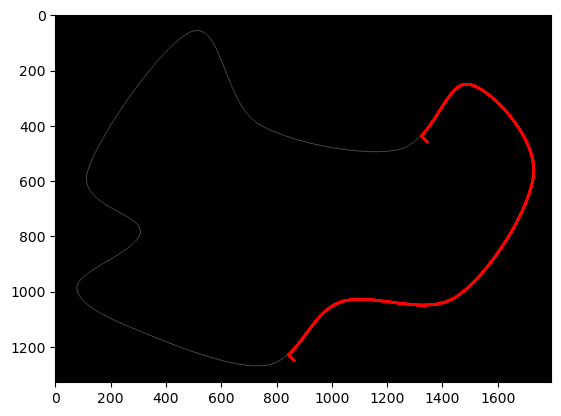

In [52]:
# Show the longest path
plt.imshow(fil.skeleton, cmap='gray')
plt.contour(fil.skeleton_longpath, colors='r')
plt.show()



In [71]:
from skimage.feature import peak_local_max
print(np.max(distance))
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=occupancy_map.grid)
print(coords)

30.4138126514911
[]


In [48]:
 # walk to end
neighbors = [Point(0, 1), Point(0, -1), Point(1, 0), Point(-1, 0),
        Point(1, 1), Point(1, -1), Point(-1, 1), Point(-1, -1)]


def find_start(center_line: np.ndarray):
    center_line = center_line.copy()
    start_point = np.argwhere(center_line != 0)[0]
    curr_point = Point(start_point[1], start_point[0])

   
    while True:
        center_line[curr_point.y, curr_point.x] = 0
        next_point = None
        for direction in neighbors:
            temp_point = curr_point + direction
            if 0<=temp_point.x < center_line.shape[1] and 0 <= temp_point.y < center_line.shape[0] and center_line[temp_point.y, temp_point.x] == 1:
                next_point = temp_point
                break
        if(next_point is None):
            break
        curr_point = next_point
    return curr_point


def get_path(start_point: Point, center_line: np.ndarray):
    center_line = center_line.copy()
    curr_point = start_point
    path = []
    while True:
        distance = distances[curr_point.y, curr_point.x]
        current_ref_point = RefPoint(curr_point.x, curr_point.y, distance, distance)
        path.append(current_ref_point)
        center_line[curr_point.y, curr_point.x] = 0
        next_point = None
        for direction in neighbors:
            temp_point = curr_point + direction
            if 0<=temp_point.x < center_line.shape[1] and 0 <= temp_point.y < center_line.shape[0] and center_line[temp_point.y, temp_point.x] == 1:
                # if not next_point is None:
                #    raise ValueError("A point should only have one valid neighbor")
                next_point = temp_point
                break
                
        if(next_point is None):
            print("reached end")
            break
        curr_point = next_point
    return path
        


start point: (864,1249)
reached end


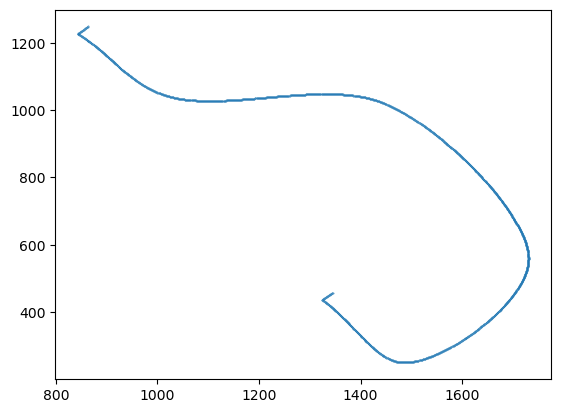

In [49]:
center_line = fil.skeleton_longpath.copy()
start_point = find_start(center_line)
print(f"start point: {start_point}")
path = get_path(start_point, center_line)
path.reverse()
plt.scatter([p.x for p in path], [p.y for p in path], s=0.1)


In [50]:
header = ['x_m', 'y_m', 'w_tr_right_m', 'w_tr_left_m']

with open('../../../to_be_saved/tracks/track_2/center_line.csv', 'w', encoding='UTF8', newline='') as f:
    path_world_coordinates = list(map(lambda point: occupancy_map.grid_point_to_world_point(
        point), path))
    
    header_str = "# "
    for word in header[:-1]:
        header_str += word +","
    header_str += header[-1]
    f.write(f"{header_str}\n")

    writer = csv.writer(f)
    path_world_coords_reformatted = list(map(lambda point: [point.x, point.y, point.w_tr_right, point.w_tr_left], path_world_coordinates))
    writer.writerows(path_world_coords_reformatted)

In [51]:

trajectory = trajectory_from_path(path, occupancy_map)
with open('../../../to_be_saved/trajectory.txt', 'w') as f:
    for pose in trajectory:
        f.write(f"{pose.coordinate.x},{pose.coordinate.y},{pose.quaternion.x},{pose.quaternion.y},{pose.quaternion.z},{pose.quaternion.w}\n")